In [11]:
# Import necessary libraries
from fastai.vision import *
from fastai.widgets import *

### Download images
The CSV files with image URLs is now uploaded to data/fordVferrari

In [5]:
folders = ['ford', 'ferrari']

for folder in folders:
    path = Path('data/fordVferrari')
    dest = path/folder
    dest.mkdir(parents=True, exist_ok=True)
    
    file = folder+'.csv'
    download_images(path/file, dest, max_pics=200)
    
path.ls()

Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '

Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '

[PosixPath('data/fordVferrari/ferrari.csv'),
 PosixPath('data/fordVferrari/ferrari'),
 PosixPath('data/fordVferrari/ford'),
 PosixPath('data/fordVferrari/ford.csv')]

Remove images that can't be opened:

In [6]:
classes = ['ford', 'ferrari']
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_size=500)

ford


ferrari


### View data

In [7]:
# Create data bunch
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [8]:
data.classes

['ferrari', 'ford']

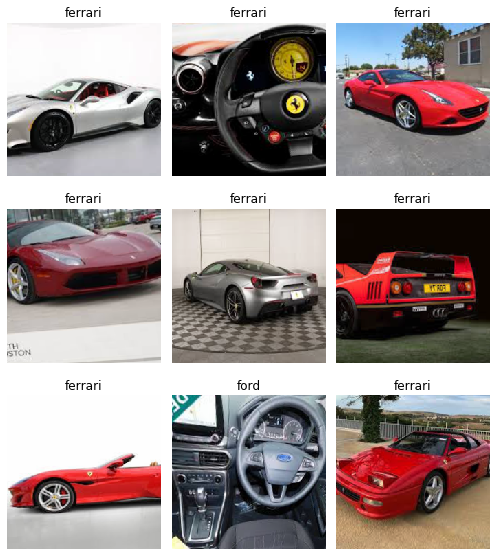

In [9]:
data.show_batch(rows=3, figsize=(7,8))

In [10]:
# Print classes, number of classes, number of photos in training set and validation set
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['ferrari', 'ford'], 2, 256, 64)

### Train model

In [13]:
# Create convolutional neural network (CNN)
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [14]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.223560,0.212014,0.093750,00:03
1,0.785208,0.254183,0.093750,00:01
2,0.602157,0.245215,0.093750,00:01
3,0.514998,0.216394,0.078125,00:01


In [15]:
learn.save('stage-1')

In [16]:
learn.unfreeze()

In [17]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


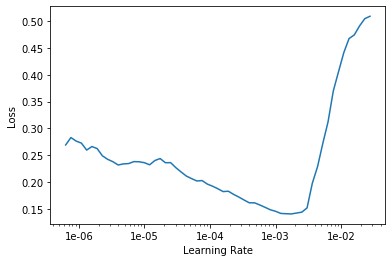

In [18]:
learn.recorder.plot()

In [19]:
learn.fit_one_cycle(2, max_lr=slice(3e-5,3e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.274432,0.202223,0.046875,00:02
1,0.203764,0.303847,0.062500,00:02


In [20]:
learn.save('stage-2')

### Interpretation

In [21]:
learn.load('stage-2');

In [22]:
interp = ClassificationInterpretation.from_learner(learn)

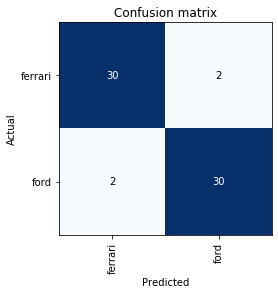

In [23]:
interp.plot_confusion_matrix()

### Clean data

In [24]:
db = (ImageList.from_folder(path)
                   .split_none()
                   .label_from_folder()
                   .transform(get_transforms(), size=224)
                   .databunch()
     )

In [25]:
learn_cln = cnn_learner(db, models.resnet34, metrics=error_rate)

learn_cln.load('stage-2');

In [26]:
ds, idxs = DatasetFormatter().from_toplosses(learn_cln)

In [27]:
# Don't run this in google colab or any other instances running jupyter lab.
# If you do run this on Jupyter Lab, you need to restart your runtime and
# runtime state including all local variables will be lost.
ImageCleaner(ds, idxs, path)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

In [28]:
db = (ImageList.from_csv(path, 'cleaned.csv', folder='.')
                    .split_none()
                    .label_from_df()
                    .transform(get_transforms(), size=224)
                    .databunch()
      )

In [29]:
learn_cln = cnn_learner(db, models.resnet34, metrics=error_rate)

learn_cln.load('stage-2');

ds, idxs = DatasetFormatter().from_similars(learn_cln)

Getting activations...


Computing similarities...


In [30]:
ImageCleaner(ds, idxs, path, duplicates=True)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

### Retrain model

In [31]:
np.random.seed(42)
data = ImageDataBunch.from_csv(path, folder=".", valid_pct=0.2, csv_labels='cleaned.csv',
         ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [32]:
# Create convolutional neural network (CNN)
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,error_rate,time
0,1.005021,0.369450,0.160714,00:01
1,0.794289,0.325919,0.071429,00:01
2,0.606972,0.271718,0.071429,00:01
3,0.484966,0.235586,0.071429,00:01
4,0.423037,0.217793,0.071429,00:01


In [33]:
learn.save('stage-3')

In [34]:
learn.unfreeze()
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


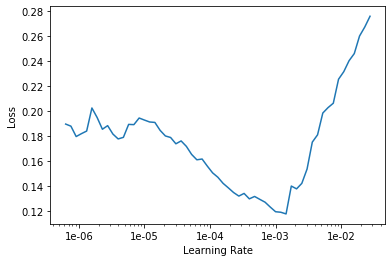

In [35]:
learn.recorder.plot()

In [38]:
learn.fit_one_cycle(2, max_lr=slice(3e-5,3e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.142017,0.178963,0.053571,00:01
1,0.087624,0.150105,0.035714,00:01


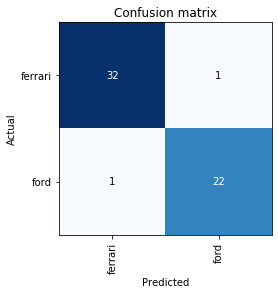

In [39]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [40]:
learn.save('stage-4')

### Production

In [41]:
learn.export()

In [42]:
path

PosixPath('data/fordVferrari')

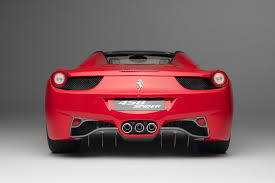

In [45]:
img = open_image(path/'ferrari'/'00000126.jpg')
img

In [46]:
learn = load_learner(path)

pred_class,pred_idx,outputs = learn.predict(img)
pred_class

Category ferrari